In [8]:
import pandas as pd
import numpy as np
from osgeo import gdal
import sys
import os
sys.path.append(os.path.join('..'))
from counting_boats.boat_utils.spatial_helpers import get_array_from_tif, use_udm_2



In [9]:
UDM_DIR = "D:/Results/UDM"
DETECTION_FILE = "D:/Results/boat_detections.csv"
print(locals().get('removed'))

[]


For each Usable Data Mask, we want to:
- Check if it is udm_2, if not then skip for now
- Grab the cloud mask 
- Grab the detections for that day
- filter out detections that are in the cloud mask -> false positives

In [11]:
CLOUD_BAND = 6
HAZE_BAND = 4
RESOLUTION = 3

filtered_detections = None
detections = pd.read_csv(DETECTION_FILE)
detections["date"] = pd.to_datetime(detections["date"], dayfirst=True)
print(f"Loaded {len(detections)} detections")

if 'removed' not in locals():
    removed = []

all_udm = [udm for udm in os.listdir(UDM_DIR) if udm.endswith("udm.tif")]

for i, udm in enumerate(sorted(all_udm)):
    date = udm.split("_")[1]
    day_detections = detections[detections["date"] == f"{date[:4]}-{date[4:6]}-{date[6:8]}"]
    if len(removed) > i and removed[i] == 0:
        print(f"Skipping {udm}, already have worked out its 0 detections")
        if filtered_detections is None:
            filtered_detections = day_detections
        else:
            filtered_detections = pd.concat([filtered_detections, day_detections])
        continue
    udm_path = f"{UDM_DIR}/{udm}"
    try:
        is_udm_2 = use_udm_2(udm_path)
    except:
        print(f"Error reading UDM from {udm_path}, skipping {udm_path}")
        continue
    print(f"Reading UDM from {udm_path}, use_udm_2: {is_udm_2}", end=" ")
    if not is_udm_2:
        print(f"Skipping {udm_path}")
        continue
    try:
        top_x, top_y, clouds = get_array_from_tif(udm_path, CLOUD_BAND)
        top_x, top_y, haze = get_array_from_tif(udm_path, HAZE_BAND)
    except:
        print(f"Error reading UDM from {udm_path}, skipping {udm_path}")
        continue
    clouds = clouds | haze 


    H, W = clouds.shape

    items_x = day_detections["epsg32756_x"]
    items_y = day_detections["epsg32756_y"]

    delta_x = items_x - top_x
    delta_y = top_y - items_y

    pixel_i = np.round(delta_y / RESOLUTION).astype(int)
    pixel_j = np.round(delta_x / RESOLUTION).astype(int)

    within_bounds = (
        (pixel_i >= 0) & (pixel_i < H) & (pixel_j >= 0) & (pixel_j < W)
    )

    pixel_i = pixel_i[within_bounds]
    pixel_j = pixel_j[within_bounds]

    cloud_values = clouds[pixel_i, pixel_j]

    not_cloudy = cloud_values == 0

    if filtered_detections is None:
        filtered_detections = day_detections[within_bounds][not_cloudy]
    else:
        filtered_detections = pd.concat(
            [filtered_detections, day_detections[within_bounds][not_cloudy]]
        )
    # count removed detections
    removed_today = len(day_detections) - len(day_detections[within_bounds][not_cloudy])
    if len(removed) > i:
        removed[i] += removed_today
    else:
        removed.append(removed_today)
    print(f"Removed {removed_today}/{len(day_detections)} detections from {udm}")

print(f"Removed {np.sum(removed)} detections")
# save filtered detections
filtered_detections.to_csv("D:/Results/filtered_detections.csv", index=False)




C:\Users\turner30\AppData\Local\Temp\ipykernel_888\1574639039.py:7: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  detections["date"] = pd.to_datetime(detections["date"], dayfirst=True)


Loaded 846566 detections
Skipping moreton_20160830_udm.tif, already have worked out its 0 detections
Skipping moreton_20161011_udm.tif, already have worked out its 0 detections
Skipping moreton_20161110_udm.tif, already have worked out its 0 detections
Reading UDM from D:/Results/UDM/moreton_20170107_udm.tif, use_udm_2: True Removed 1/49 detections from moreton_20170107_udm.tif
Reading UDM from D:/Results/UDM/moreton_20170111_udm.tif, use_udm_2: True Removed 8/96 detections from moreton_20170111_udm.tif
Reading UDM from D:/Results/UDM/moreton_20170112_udm.tif, use_udm_2: True Removed 18/606 detections from moreton_20170112_udm.tif
Reading UDM from D:/Results/UDM/moreton_20170116_udm.tif, use_udm_2: True Removed 1/140 detections from moreton_20170116_udm.tif
Reading UDM from D:/Results/UDM/moreton_20170125_udm.tif, use_udm_2: True Removed 9/65 detections from moreton_20170125_udm.tif
Reading UDM from D:/Results/UDM/moreton_20170130_udm.tif, use_udm_2: True Removed 3/686 detections from 

OSError: [Errno 22] Invalid argument: 'D:/Results/filtered_detections.csv'

In [12]:
filtered_detections.to_csv("D:/Results/filtered_detections.csv", index=False)

In [16]:
print(filtered_detections.size)
print(sum(removed))

5739921
71362


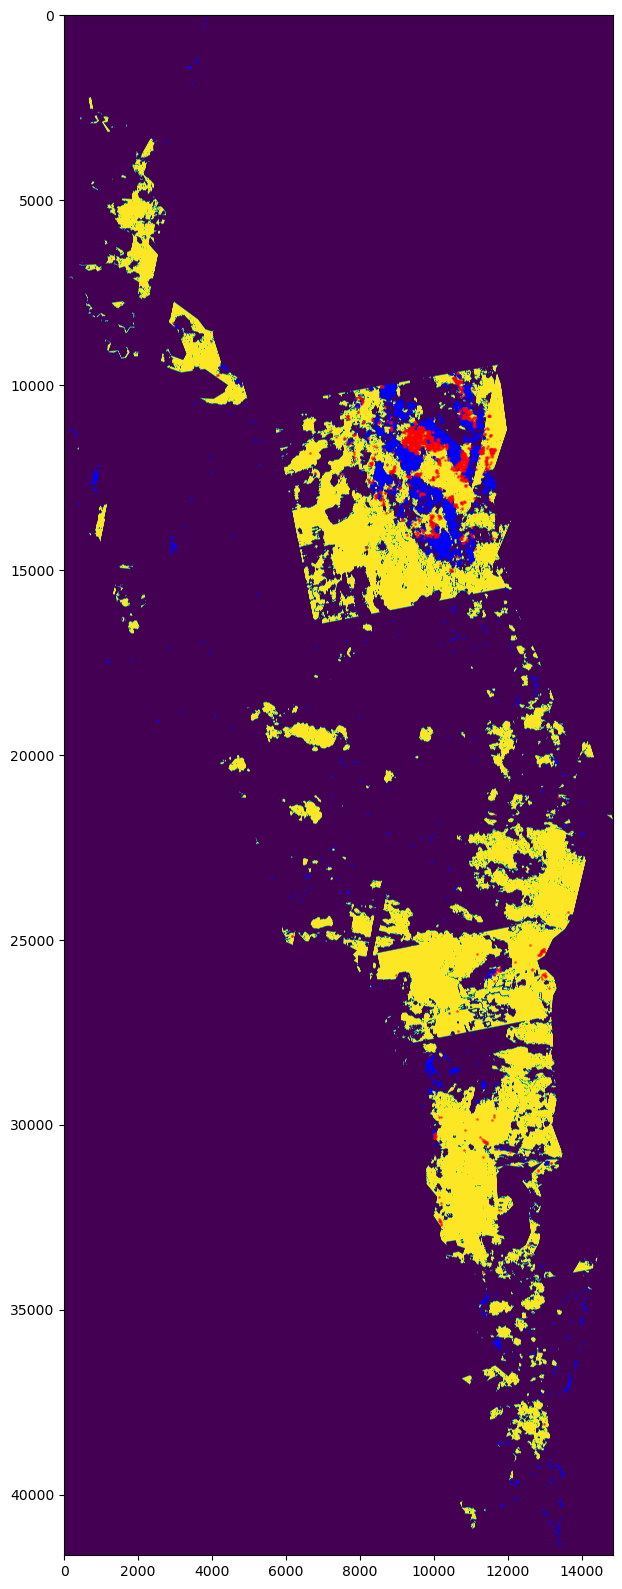

In [24]:

# imshow the cloud mask and then plot all detectinos on top (red if cloudy)
import matplotlib.pyplot as plt
# Set the figure size to be 10 inches wide
plt.figure(figsize=(20, 20))

# Display the image
plt.imshow(clouds)

# Plot the scatter points with smaller markers
plt.scatter(pixel_j[not_cloudy], pixel_i[not_cloudy], c='b', s=1, alpha=0.5)
plt.scatter(pixel_j[~not_cloudy], pixel_i[~not_cloudy], c='r', s=1, alpha=0.5)

# Show the plot
plt.show()



